In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns

## Goal: Train RF and make predictions per each player

In [4]:
# Read in data
feature_set_2021 = pd.read_csv('../data/stats/past_seasons/combined_per60_roll15_2021.csv')
feature_set_2022 = pd.read_csv('../data/stats/past_seasons/combined_per60_roll15_2022.csv')
feature_set_2023 = pd.read_csv('../data/stats/past_seasons/combined_per60_roll15_2023.csv')

feature_set_all = pd.concat([feature_set_2021, feature_set_2022, feature_set_2023], axis=0).reset_index(drop = True)
#print(feature_set_all.info())
feature_set_all.head()

,s_player_id,s_name,s_age,season,s_game_num,date,s_team,s_opponent,s_home_away_status,s_result,...,g_age,g_game_num,decision,g_n_completed_games,GA_60,SA_60,SV_60,total_shutout,SV_perc,g_avg_TOI
0,/a/abramvi01,Vitaly Abramov,22,2021,1,2021-05-05,OTT,MTL,1,W,...,30,26,L,25,2.737591,27.786544,25.048953,0.0,0.901478,58.445556
1,/a/abramvi01,Vitaly Abramov,23,2021,2,2021-05-08,OTT,WPG,0,W,...,27,43,L,42,2.688031,30.004238,27.316207,2.0,0.910412,55.058889
2,/a/acciano01,Noel Acciari,29,2021,1,2021-01-17,FLA,CHI,1,W,...,26,2,L,1,5.000000,37.000000,32.000000,0.0,0.864865,60.000000
3,/a/acciano01,Noel Acciari,29,2021,2,2021-01-19,FLA,CHI,1,W,...,25,1,O,0,NaN,NaN,NaN,0.0,NaN,NaN
4,/a/acciano01,Noel Acciari,29,2021,3,2021-01-26,FLA,CBJ,0,W,...,26,4,O,3,2.338313,36.076830,33.738517,0.0,0.935185,59.872222


In [3]:
# First date that we began recording odds. This will be used to split the training and testing data
first_date = pd.read_csv('../data/odds/ml_odds.csv')['date_game'].min()
first_date

'2023-02-13'

In [6]:
# Split feature set into train and test
feature_set_for_preds = feature_set_all.loc[feature_set_all['date'] >= first_date, ['s_player_id', 's_name', 's_team', 'date', 's_result', 'G']]
train = feature_set_all.loc[feature_set_all['date'] < first_date, ['G', 'P_60', 'G_60', 'S_60', 'PPG_60', 'PPA_60', 'BLK_60', 's_avg_TOI']].dropna()
test = feature_set_all.loc[feature_set_all['date'] >= first_date, ['G', 'P_60', 'G_60', 'S_60', 'PPG_60', 'PPA_60', 'BLK_60', 's_avg_TOI']].dropna()

In [7]:
# Train using everything prior to the test set
x_train = train.drop(columns = ['G'])
x_test = test.drop(columns = ['G'])

y_train = train['G']
y_test = test['G']

# Find average goals per game that we can use to impute situations where no prediction was made about a player
avg_G_per_game = y_train.mean()
print(avg_G_per_game)

0.17019471828994742


In [8]:
# Train RF using parameters from model exploration notebook
rf = RandomForestRegressor(max_depth=5, n_estimators=50)
rf.fit(x_train, y_train)

# Make predictions about each player's goals per game
preds = pd.DataFrame({'preds':rf.predict(x_test)}, index = test.index)

In [11]:
# For anyone that we did not make a prediction for, fill with the average goals per game
player_predictions = pd.merge(feature_set_for_preds, preds, left_index=True, right_index=True, how = 'left').fillna({'preds':avg_G_per_game})
player_predictions.head()

,s_player_id,s_name,s_team,date,s_result,G,preds
78430,/a/abruzni01,Nicholas Abruzzese,TOR,2023-04-02,L,0,0.170195
78431,/a/abruzni01,Nicholas Abruzzese,TOR,2023-04-04,W,0,0.150308
78484,/a/acciano01,Noel Acciari,STL,2023-02-14,W,0,0.116603
78485,/a/acciano01,Noel Acciari,STL,2023-02-16,W,0,0.118048
78486,/a/acciano01,Noel Acciari,TOR,2023-02-18,W,0,0.132670


## Export predictions

In [13]:
player_predictions.to_csv('../data/evaluation_predictions/rf_test_021323.csv', header=True, index=False)

## Everything below here move to new notebook

In [101]:
odds.head()

,Unnamed: 0,date_recorded,time_recorded,game_id,date_game,time_game,team,ml_odds
0,0.0,2023-02-13,14:00:00,1,2023-02-13,NaN,CGY Flames,−165
1,1.0,2023-02-13,14:00:00,1,2023-02-13,NaN,OTT Senators,+140
2,2.0,2023-02-13,14:00:00,2,2023-02-13,NaN,ARI Coyotes,+200
3,3.0,2023-02-13,14:00:00,2,2023-02-13,NaN,NSH Predators,−240
4,4.0,2023-02-13,14:00:00,3,2023-02-13,NaN,FLA Panthers,−110


In [126]:
# Get the number of goals scored by each team on each day. 
team_total_G = player_predictions.groupby(['s_team', 'date'])['G'].sum().reset_index()

# Create a column that is the result of each bet. For every team and date, did the team win.
game_results = feature_set_for_preds.groupby(['s_team', 'date'])['s_result'].agg(game_result = pd.Series.mode).reset_index()

odds['team_trunc'] = odds['team'].str.slice(0, 3)
odds_results = pd.merge(odds, game_results, how = 'left', left_on=['team_trunc', 'date_game'], right_on = ['s_team', 'date']).drop(columns=['s_team', 'date'])
odds_results['bet_outcome'] = [1 if result == 'W' else 0 for result in odds_results['game_result']]
odds_results.drop(columns='game_result', inplace=True)

odds_results.head()

,Unnamed: 0,date_recorded,time_recorded,game_id,date_game,time_game,team,ml_odds,team_trunc,bet_outcome
0,0.0,2023-02-13,14:00:00,1,2023-02-13,NaN,CGY Flames,−165,CGY,0
1,1.0,2023-02-13,14:00:00,1,2023-02-13,NaN,OTT Senators,+140,OTT,1
2,2.0,2023-02-13,14:00:00,2,2023-02-13,NaN,ARI Coyotes,+200,ARI,1
3,3.0,2023-02-13,14:00:00,2,2023-02-13,NaN,NSH Predators,−240,NSH,0
4,4.0,2023-02-13,14:00:00,3,2023-02-13,NaN,FLA Panthers,−110,FLA,1


In [77]:
# Find the expected number of goals for each team for each day
num_players_per_game = player_predictions.groupby(['s_team', 'date'])['s_player_id'].count().reset_index().rename(columns={'s_player_id':'n_players'})
num_players_per_game.head()

,s_team,date,n_players
0,ANA,2023-02-15,18
1,ANA,2023-02-17,18
2,ANA,2023-02-20,18
3,ANA,2023-02-21,18
4,ANA,2023-02-23,18


In [79]:
num_players_per_game.loc[num_players_per_game['n_players'] != 18, :]

,s_team,date,n_players
45,ARI,2023-03-21,17
48,ARI,2023-03-26,17
174,CBJ,2023-04-11,17
205,CGY,2023-04-12,17
328,EDM,2023-02-17,17
329,EDM,2023-02-19,17
456,MTL,2023-03-18,17
505,NSH,2023-02-26,17
563,NYR,2023-02-26,17
564,NYR,2023-03-01,16


In [127]:
team_xGoals = player_predictions.groupby(['s_team', 'date'])['preds'].sum().reset_index().rename(columns={'preds':'xG'})
team_xGoals = pd.merge(team_xGoals, num_players_per_game, how = 'left', on = ['s_team', 'date'])
team_xGoals['xG'] = (team_xGoals['xG'] + avg_G_per_game * (18 - team_xGoals['n_players']))
team_xGoals.drop(columns='n_players', inplace = True)

team_xGoals.head()

,s_team,date,xG
0,ANA,2023-02-15,2.976316
1,ANA,2023-02-17,2.857251
2,ANA,2023-02-20,2.987626
3,ANA,2023-02-21,2.957708
4,ANA,2023-02-23,2.873595


<Axes: xlabel='xG', ylabel='Count'>

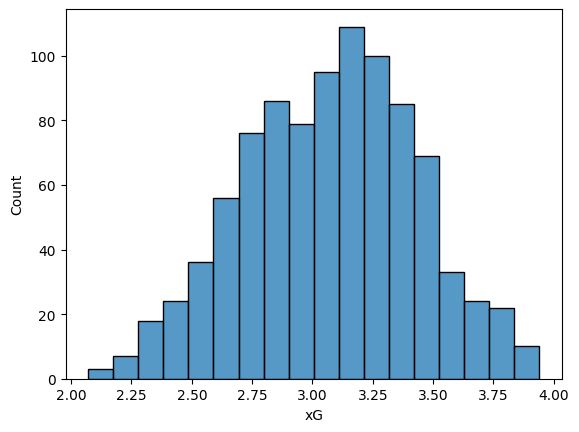

In [129]:
sns.histplot(data=team_xGoals, x = 'xG')

,s_team,date,game_result
0,ANA,2023-02-15,L
1,ANA,2023-02-17,L
2,ANA,2023-02-20,L-OT
3,ANA,2023-02-21,L
4,ANA,2023-02-23,W
...,...,...,...
927,WSH,2023-04-06,L
928,WSH,2023-04-08,L
929,WSH,2023-04-10,W
930,WSH,2023-04-11,L


In [132]:
odds

,Unnamed: 0,date_recorded,time_recorded,game_id,date_game,time_game,team,ml_odds,team_trunc
0,0.0,2023-02-13,14:00:00,1,2023-02-13,NaN,CGY Flames,−165,CGY
1,1.0,2023-02-13,14:00:00,1,2023-02-13,NaN,OTT Senators,+140,OTT
2,2.0,2023-02-13,14:00:00,2,2023-02-13,NaN,ARI Coyotes,+200,ARI
3,3.0,2023-02-13,14:00:00,2,2023-02-13,NaN,NSH Predators,−240,NSH
4,4.0,2023-02-13,14:00:00,3,2023-02-13,NaN,FLA Panthers,−110,FLA
...,...,...,...,...,...,...,...,...,...
927,NaN,2023-04-13,11:41:31,464,2023-04-13,21:30:00,SEA Kraken,+100,SEA
928,NaN,2023-04-14,09:13:28,465,2023-04-14,18:38:00,BUF Sabres,−170,BUF
929,NaN,2023-04-14,09:13:28,465,2023-04-14,18:38:00,CBJ Blue Jackets,+145,CBJ
930,NaN,2023-04-14,09:13:50,466,2023-04-14,19:00:00,COL Avalanche,−225,COL


In [144]:
# Create poisson probability for each game
poisson_input = pd.merge(team_xGoals, odds[['team_trunc', 'date_game', 'game_id']], how = 'left', left_on = ['s_team', 'date'], right_on = ['team_trunc', 'date_game'])
poisson_input.loc[poisson_input['team_trunc'].isna(), 's_team'].unique()

array(['LAK', 'NJD', 'NYI', 'NYR', 'SJS', 'TBL', 'VEG', 'WSH'],
      dtype=object)